In [1]:
import pandas as pd
import numpy as np
from modules import data_sampling, SimRank, evaluation
from sklearn.model_selection import train_test_split

# Loading & Manipulating Data

In [19]:
# Load data
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('genome-scores.csv')

In [3]:
# Keep movies have tags
# set threhod when using jaccard sim
tags = tags[tags.relevance > 0.5]

ratings, tags = data_sampling.align_items(ratings, tags)

In [4]:
# sampling
rating_sample = data_sampling.sample_df(ratings, user_sample_n = 2000, item_sample_n = 200)

number of users: 2000
number of items: 200
number of ratings: 68263


In [5]:
# Train test split
rating_train, rating_test = train_test_split(rating_sample, test_size=0.10, random_state=42)

In [2]:
e = [['A', 1, 5], ['A', 2, 5], ['B', 1, 1], ['B', 2, 1], ['B', 3, 5], ['C', 3, 3]]
e = pd.DataFrame(e, columns = ['userId', 'movieId', 'rating'])
e

,userId,movieId,rating
0,A,1,5
1,A,2,5
2,B,1,1
3,B,2,1
4,B,3,5
5,C,3,3


In [3]:
wbs = SimRank.weighted_bipartite_simrank()

In [4]:
wbs.fit(e)

User count: 3, item count: 3
Initializing user-W matrix...
Finished in 0.002385854721069336s!
Initializing item-W matrix...
Finished in 0.001499176025390625s!
Initializing user evidence matrix...
Finished in 0.005595207214355469s!
Initializing item evidence matrix...
Finished in 0.01641392707824707s!
Iteration 1 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.0002570152282714844, S_item updated in 0.00011301040649414062!
Iteration 2 / 100 start:
GPU failed, trying with CPU...
S_user updated in 5.1021575927734375e-05, S_item updated in 5.793571472167969e-05!
Converged at iteration 2, break!


In [47]:
t = [
        [1, 1, 1], [1, 2, 1], [1, 3, 1], [1,4,0],
        [2, 1, 1], [2, 2, 1], [2, 3, 1], [2,4,0],
        [3, 1, 1], [3, 2, 0], [3, 3, 0], [3,4,1],
    ]
t = pd.DataFrame(t, columns = ['movieId', 'tagId', 'relevance'])
t

,movieId,tagId,relevance
0,1,1,1
1,1,2,1
2,1,3,1
3,1,4,0
4,2,1,1
5,2,2,1
6,2,3,1
7,2,4,0
8,3,1,1
9,3,2,0


In [46]:
wbs.S_item*100000

movieId,1,2,3
movieId,,,
1,100000.000000,0.004877,0.189714
2,0.004877,100000.000000,0.189714
3,0.189714,0.189714,100000.000000


In [48]:
tsr_jac = SimRank.tag_simrank()

In [49]:
tsr_jac.fit(e, t, C_item = 0.8, C_user = 0.8, lbd = 0.000001, iterations = 100, eps = 1e-4, how = 'jac')

User count: 3, item count: 3
Initializing tab-based item similarity matrix...
Finished in 0.019143104553222656s!
Initializing user-W matrix...
Finished in 0.005758047103881836s!
Initializing item-W matrix...
Finished in 0.0043010711669921875s!
Initializing user evidence matrix...
Finished in 0.013767242431640625s!
Initializing item evidence matrix...
Finished in 0.014946937561035156s!
Iteration 1 / 100 start:
GPU failed, trying with CPU...
S_user updated in 5.2928924560546875e-05, S_item updated in 3.695487976074219e-05!
Converged at iteration 1, break!


In [50]:
tsr_jac.S_item*1000000

movieId,1,2,3
movieId,,,
1,1000000.000000,1.110329,0.317483
2,1.110329,1000000.000000,0.317483
3,0.317483,0.317483,1000000.000000


# TagSimRank

In [60]:
# Init instance
tsr_jac = SimRank.tag_simrank()

In [7]:
# train
tsr_jac.fit(rating_train, tags, C_item = 0.8, C_user = 0.8, lbd = 0.3, iterations = 100, eps = 1e-4, how = 'jac')

User count: 2000, item count: 200
Initializing tab-based item similarity matrix...
Finished in 60.418962240219116s!
Initializing user-W matrix...
Finished in 0.05829787254333496s!
Initializing item-W matrix...
Finished in 0.012812137603759766s!
Initializing user evidence matrix...
Finished in 1.0216031074523926s!
Initializing item evidence matrix...
Finished in 1.747237205505371s!
Iteration 1 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.03529977798461914, S_item updated in 0.06808924674987793!
Iteration 2 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.04143214225769043, S_item updated in 0.07285308837890625!
Iteration 3 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.03964519500732422, S_item updated in 0.05158877372741699!
Converged at iteration 3, break!


In [8]:
# predict
tsr_jac_pred = tsr_jac.cf_recommendation(rating_test)

Count of cold start user: 0
Count of cold start item: 0
191/1906 completed
382/1906 completed
572/1906 completed
763/1906 completed
953/1906 completed
1144/1906 completed
1335/1906 completed
1525/1906 completed
1716/1906 completed
1906/1906 completed


In [9]:
user_grouped = evaluation.group(rating_test, 'user')

In [10]:
# Evaluation
tsr_precision = evaluation.precision_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)
print(f"Precision: {tsr_precision}")
tsr_recall = evaluation.recall_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)
print(f"Recall: {tsr_recall}")
tsr_ndcg = evaluation.ndcg_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)
print(f"ndcg: {tsr_ndcg}")

Precision: 0.07177334732423926
Recall: 0.20688978882840373
ndcg: 0.16541804108139532


In [ ]:
# aggrate evaluation
precision, recall, ndcg = evaluation.evaluation_at_k(
    rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped
)

Recall for each user group:  {'0-5': 0.0584, '5-10': 0.1335, '10-50': 0.232}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


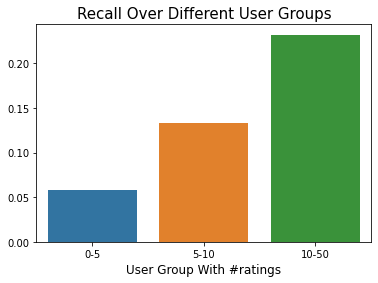

{'0-5': 0.0584, '5-10': 0.1335, '10-50': 0.232}

In [11]:
evaluation.precision_over_user_group(rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped)

Recall for each user group:  {'0-5': 0.2096, '5-10': 0.1939, '10-50': 0.1815}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


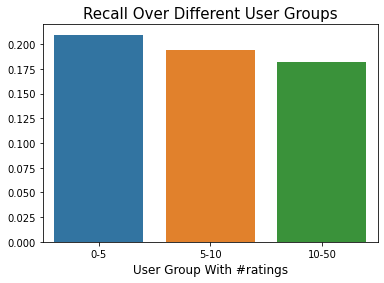

{'0-5': 0.2096, '5-10': 0.1939, '10-50': 0.1815}

In [12]:
evaluation.recall_over_user_group(rating_test,
    tsr_jac_pred,
    user_grouped = user_grouped)

In [13]:
# Evaluation
tsr_precision = evaluation.precision_at_k(
    rating_test,
    tsr_pred,
    user_grouped = user_grouped
)
print(f"Precision: {tsr_precision}")
tsr_recall = evaluation.recall_at_k(
    rating_test,
    tsr_pred,
    user_grouped = user_grouped
)
print(f"Recall: {tsr_recall}")
tsr_ndcg = evaluation.ndcg_at_k(
    rating_test,
    tsr_pred,
    user_grouped = user_grouped
)
print(f"ndcg: {tsr_ndcg}")

Precision: 0.10493204283360792
Recall: 0.17899064676510162
Recall: 0.17582168273247448


# Weighted Bipartite SimRank

In [13]:
# Init instance
wbs = SimRank.weighted_bipartite_simrank()

In [14]:
wbs.fit(rating_train)

User count: 2000, item count: 200
Initializing user-W matrix...
Finished in 0.05991005897521973s!
Initializing item-W matrix...
Finished in 0.013983964920043945s!
Initializing user evidence matrix...
Finished in 1.1156260967254639s!
Initializing item evidence matrix...
Finished in 1.743818998336792s!
Iteration 1 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.03458380699157715, S_item updated in 0.06656098365783691!
Iteration 2 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.03442811965942383, S_item updated in 0.07073688507080078!
Iteration 3 / 100 start:
GPU failed, trying with CPU...
S_user updated in 0.055589914321899414, S_item updated in 0.05883431434631348!
Converged at iteration 3, break!


In [15]:
wbs_pred = wbs.cf_recommendation(rating_test)

Count of cold start user: 0
Count of cold start item: 0
191/1906 completed
382/1906 completed
572/1906 completed
763/1906 completed
953/1906 completed
1144/1906 completed
1335/1906 completed
1525/1906 completed
1716/1906 completed
1906/1906 completed


In [16]:
# Evaluation
wbs_precision = evaluation.precision_at_k(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped
)
print(f"Precision: {wbs_precision}")
wbs_recall = evaluation.recall_at_k(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped
)
print(f"Recall: {wbs_recall}")
wbs_ndcg = evaluation.ndcg_at_k(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped
)
print(f"ndcg: {wbs_ndcg}")

Precision: 0.07738719832109131
Recall: 0.21940910902086141
ndcg: 0.1733192177928342


Recall for each user group:  {'0-5': 0.0622, '5-10': 0.148, '10-50': 0.256}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


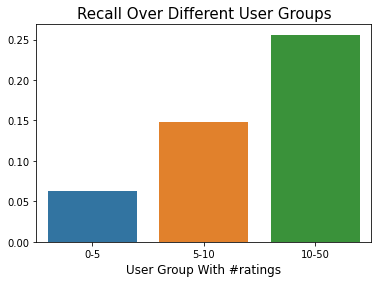

{'0-5': 0.0622, '5-10': 0.148, '10-50': 0.256}

In [17]:
evaluation.precision_over_user_group(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped)

Recall for each user group:  {'0-5': 0.2203, '5-10': 0.2157, '10-50': 0.2015}


/Users/mac/anaconda2/envs/py36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


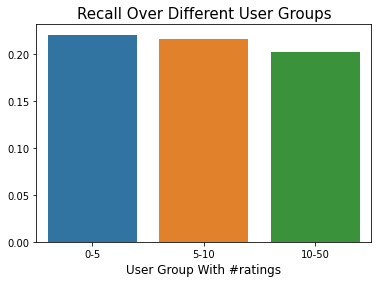

{'0-5': 0.2203, '5-10': 0.2157, '10-50': 0.2015}

In [18]:
evaluation.recall_over_user_group(
    rating_test,
    wbs_pred,
    user_grouped = user_grouped)

In [2]:
import pickle as pkl
import pandas as pd

In [49]:
f = open('grid_search_reversed_rst.pkl', 'rb')
grid_search_reversed_rst = pkl.load(f)
f.close()

In [50]:
pd.DataFrame(grid_search_reversed_rst)

,lbd,cutoff,k_neighbors,k_matric,precision_tag_cos,recall_tag_cos,ndcg_tag_cos,precision_tag_jac,recall_tag_jac,ndcg_tag_jac,...,recall_cf,ndcg_cf,group_precision_tag_cos,group_recall_tag_cos,group_precision_tag_jac,group_recall_tag_jac,group_precision_wbs,group_recall_wbs,group_precision_cf,group_recall_cf
0,0.9,0.5,10,1,0.192384,0.035498,0.192384,0.207832,0.038551,0.207832,...,0.043044,0.268188,"{'0-10': 0.0682, '10-50': 0.1717, '50-100': 0....","{'0-10': 0.0353, '10-50': 0.0396, '50-100': 0....","{'0-10': 0.0695, '10-50': 0.1824, '50-100': 0....","{'0-10': 0.0376, '10-50': 0.0433, '50-100': 0....","{'0-10': 0.0695, '10-50': 0.139, '50-100': 0.2...","{'0-10': 0.0359, '10-50': 0.0322, '50-100': 0....","{'0-10': 0.0675, '10-50': 0.2129, '50-100': 0....","{'0-10': 0.0364, '10-50': 0.0476, '50-100': 0...."
1,0.9,0.5,10,2,0.164272,0.057093,0.173357,0.175498,0.065846,0.186815,...,0.071118,0.246191,"{'0-10': 0.0556, '10-50': 0.141, '50-100': 0.2...","{'0-10': 0.0572, '10-50': 0.0623, '50-100': 0....","{'0-10': 0.0652, '10-50': 0.1523, '50-100': 0....","{'0-10': 0.0699, '10-50': 0.0714, '50-100': 0....","{'0-10': 0.0497, '10-50': 0.1087, '50-100': 0....","{'0-10': 0.0505, '10-50': 0.0499, '50-100': 0....","{'0-10': 0.054, '10-50': 0.1782, '50-100': 0.4...","{'0-10': 0.0554, '10-50': 0.0786, '50-100': 0...."
2,0.9,0.5,10,3,0.146698,0.071786,0.164123,0.154901,0.085176,0.176425,...,0.092149,0.231212,"{'0-10': 0.0466, '10-50': 0.1195, '50-100': 0....","{'0-10': 0.07, '10-50': 0.0771, '50-100': 0.04...","{'0-10': 0.0565, '10-50': 0.1345, '50-100': 0....","{'0-10': 0.0893, '10-50': 0.092, '50-100': 0.0...","{'0-10': 0.0415, '10-50': 0.0947, '50-100': 0....","{'0-10': 0.0629, '10-50': 0.0638, '50-100': 0....","{'0-10': 0.0475, '10-50': 0.1547, '50-100': 0....","{'0-10': 0.0731, '10-50': 0.1006, '50-100': 0...."
3,0.9,0.5,10,4,0.133914,0.085148,0.159328,0.140650,0.100032,0.171602,...,0.108700,0.222727,"{'0-10': 0.0407, '10-50': 0.1077, '50-100': 0....","{'0-10': 0.0798, '10-50': 0.092, '50-100': 0.0...","{'0-10': 0.0485, '10-50': 0.1209, '50-100': 0....","{'0-10': 0.1018, '10-50': 0.1085, '50-100': 0....","{'0-10': 0.0364, '10-50': 0.0838, '50-100': 0....","{'0-10': 0.073, '10-50': 0.0742, '50-100': 0.0...","{'0-10': 0.0412, '10-50': 0.1379, '50-100': 0....","{'0-10': 0.0842, '10-50': 0.1184, '50-100': 0...."
4,0.9,0.5,10,5,0.123981,0.097698,0.157275,0.131561,0.115128,0.170931,...,0.123445,0.217375,"{'0-10': 0.0375, '10-50': 0.097, '50-100': 0.1...","{'0-10': 0.0938, '10-50': 0.1034, '50-100': 0....","{'0-10': 0.0441, '10-50': 0.1117, '50-100': 0....","{'0-10': 0.116, '10-50': 0.1248, '50-100': 0.0...","{'0-10': 0.0334, '10-50': 0.0765, '50-100': 0....","{'0-10': 0.0843, '10-50': 0.0843, '50-100': 0....","{'0-10': 0.0364, '10-50': 0.1249, '50-100': 0....","{'0-10': 0.0931, '10-50': 0.1346, '50-100': 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.9,0.1,80,6,0.151458,0.150301,0.213565,0.151189,0.151439,0.209790,...,0.171521,0.259619,"{'0-10': 0.0446, '10-50': 0.123, '50-100': 0.2...","{'0-10': 0.1398, '10-50': 0.1637, '50-100': 0....","{'0-10': 0.0459, '10-50': 0.1224, '50-100': 0....","{'0-10': 0.1462, '10-50': 0.1628, '50-100': 0....","{'0-10': 0.043, '10-50': 0.1184, '50-100': 0.2...","{'0-10': 0.1349, '10-50': 0.1592, '50-100': 0....","{'0-10': 0.0434, '10-50': 0.1425, '50-100': 0....","{'0-10': 0.1376, '10-50': 0.1868, '50-100': 0...."
176,0.9,0.1,80,7,0.141394,0.162442,0.212371,0.140650,0.161723,0.208185,...,0.184756,0.257894,"{'0-10': 0.0406, '10-50': 0.1144, '50-100': 0....","{'0-10': 0.1493, '10-50': 0.1773, '50-100': 0....","{'0-10': 0.0412, '10-50': 0.1136, '50-100': 0....","{'0-10': 0.1526, '10-50': 0.1749, '50-100': 0....","{'0-10': 0.0393, '10-50': 0.1089, '50-100': 0....","{'0-10': 0.1441, '10-50': 0.17, '50-100': 0.09...","{'0-10': 0.0389, '10-50': 0.1325, '50-100': 0....","{'0-10': 0.1446, '10-50': 0.2006, '50-100': 0...."
177,0.9,0.1,80,8,0.132455,0.171226,0.211182,0.1311

In [44]:
0.9,0.5; 

array([0.5, 0.1])

In [55]:
f = open('grid_search_reversed_rst_new.pkl', 'rb')
grid_search_reversed_rst_new = pkl.load(f)
f.close()

In [56]:
pd.DataFrame(grid_search_reversed_rst_new)

,lbd,cutoff,k_neighbors,k_matric,precision_tag_cos,recall_tag_cos,ndcg_tag_cos,precision_tag_jac,recall_tag_jac,ndcg_tag_jac,...,recall_cf,ndcg_cf,group_precision_tag_cos,group_recall_tag_cos,group_precision_tag_jac,group_recall_tag_jac,group_precision_wbs,group_recall_wbs,group_precision_cf,group_recall_cf
0,0.9,0.1,100,5,0.167918,0.141989,0.220673,0.165260,0.139656,0.214914,...,0.160361,0.266048,"{'0-10': 0.049, '10-50': 0.1401, '50-100': 0.2...","{'0-10': 0.1295, '10-50': 0.1575, '50-100': 0....","{'0-10': 0.0493, '10-50': 0.1359, '50-100': 0....","{'0-10': 0.1315, '10-50': 0.1525, '50-100': 0....","{'0-10': 0.0486, '10-50': 0.1354, '50-100': 0....","{'0-10': 0.1283, '10-50': 0.1526, '50-100': 0....","{'0-10': 0.0491, '10-50': 0.1599, '50-100': 0....","{'0-10': 0.1324, '10-50': 0.1751, '50-100': 0...."
1,0.9,0.2,100,5,0.167918,0.141989,0.220673,0.167882,0.141640,0.219576,...,0.160361,0.266048,"{'0-10': 0.049, '10-50': 0.1401, '50-100': 0.2...","{'0-10': 0.1295, '10-50': 0.1575, '50-100': 0....","{'0-10': 0.0494, '10-50': 0.1389, '50-100': 0....","{'0-10': 0.1335, '10-50': 0.1547, '50-100': 0....","{'0-10': 0.0486, '10-50': 0.1354, '50-100': 0....","{'0-10': 0.1283, '10-50': 0.1526, '50-100': 0....","{'0-10': 0.0491, '10-50': 0.1599, '50-100': 0....","{'0-10': 0.1324, '10-50': 0.1751, '50-100': 0...."
2,0.9,0.3,100,5,0.167918,0.141989,0.220673,0.171762,0.144199,0.225462,...,0.160361,0.266048,"{'0-10': 0.049, '10-50': 0.1401, '50-100': 0.2...","{'0-10': 0.1295, '10-50': 0.1575, '50-100': 0....","{'0-10': 0.0502, '10-50': 0.1412, '50-100': 0....","{'0-10': 0.1351, '10-50': 0.1575, '50-100': 0....","{'0-10': 0.0486, '10-50': 0.1354, '50-100': 0....","{'0-10': 0.1283, '10-50': 0.1526, '50-100': 0....","{'0-10': 0.0491, '10-50': 0.1599, '50-100': 0....","{'0-10': 0.1324, '10-50': 0.1751, '50-100': 0...."
3,0.9,0.4,100,5,0.167918,0.141989,0.220673,0.176971,0.146433,0.230743,...,0.160361,0.266048,"{'0-10': 0.049, '10-50': 0.1401, '50-100': 0.2...","{'0-10': 0.1295, '10-50': 0.1575, '50-100': 0....","{'0-10': 0.0494, '10-50': 0.1447, '50-100': 0....","{'0-10': 0.1325, '10-50': 0.1612, '50-100': 0....","{'0-10': 0.0486, '10-50': 0.1354, '50-100': 0....","{'0-10': 0.1283, '10-50': 0.1526, '50-100': 0....","{'0-10': 0.0491, '10-50': 0.1599, '50-100': 0....","{'0-10': 0.1324, '10-50': 0.1751, '50-100': 0...."
